In [1]:
# Import Module
!pip install uproot awkward

import uproot, glob, os, random
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from tqdm import tqdm
import pandas as pd
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 16.0 # Use 14 point font
sns.set(style="whitegrid")

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Di-Tau/'

branches = ['ditau_pt', 'n_subjets', 'IsTruthHadronic', 'n_tracks_lead', 'n_tracks_subl',
 'R_max_lead', 'R_max_subl', 'R_tracks_subl', 'R_isotrack', 'd0_leadtrack_lead',
 'd0_leadtrack_subl', 'f_core_lead', 'f_core_subl', 'f_subjet_subl', 'f_subjets',
 'f_isotracks', 'm_core_lead', 'm_core_subl', 'm_tracks_lead', 'm_tracks_subl',
 'n_track']

training_vars = [
    "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
    "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl", "m_core_lead",
    "m_core_subl", "m_tracks_lead", "m_tracks_subl", "d0_leadtrack_lead",
    "d0_leadtrack_subl", "n_track", "n_tracks_lead"
]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.4/350.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 787.9/787.9 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 707.9/707.9 kB 43.4 MB/s eta 0:00:00
Mounted at /content/drive


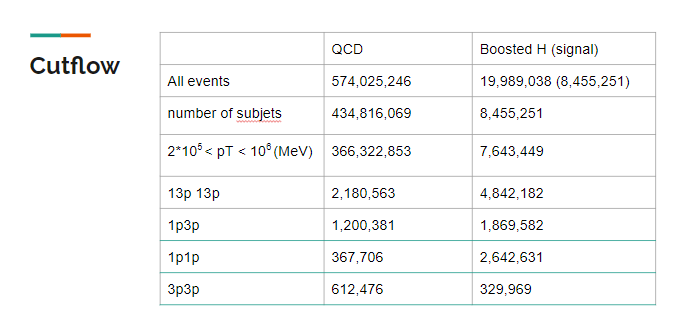

In [2]:
%%time

signal = pd.read_csv(path+'combined_signal_inc_3.csv')
bkg = pd.read_csv(path+'combined_bkg_inc_3.csv')

signal['label'] = 1
bkg['label'] = 0
signal['weight'] = signal['event_weight'] * signal['pT_weight']
bkg['weight'] = bkg['event_weight'] * bkg['pT_weight']

df = pd.concat((bkg, signal))
df = df[4:] # get rid of jz0 and jz1
df = df[df.f_core_subl != -999]
df.describe()

CPU times: user 18.2 s, sys: 2.17 s, total: 20.4 s
Wall time: 27.5 s


,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,n_tracks_subl,n_subjets,event_weight,bdt_score,bdt_score_new,eta,average_mu,pT_weight,label,weight
count,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,...,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06
mean,1.304449e+08,4.578018e+05,4.435715e-01,8.694096e-01,5.998035e-01,1.350127e-01,8.506222e-01,1.184020e-02,6.359344e-02,8.436849e-02,...,1.583997e+00,2.377956e+00,1.342479e-04,6.013966e-01,4.548350e-01,3.299539e-03,4.211670e+01,6.925447e+08,4.435697e-01,1.334122e-05
std,1.531500e+08,1.892334e+05,4.968057e-01,9.469192e-02,2.777301e-01,1.256532e-01,1.077968e-01,5.216481e-02,6.513189e-02,6.612241e-02,...,9.093636e-01,7.787370e-01,1.329443e-03,1.449452e-01,4.531641e-01,1.094215e+00,1.226566e+01,2.504325e+09,4.968055e-01,4.255651e-05
min,3.205000e+03,2.000000e+05,0.000000e+00,1.246108e-03,2.094379e-04,1.801535e-03,3.916248e-02,0.000000e+00,7.248037e-06,1.008136e-05,...,1.000000e+00,2.000000e+00,3.660355e-18,2.524264e-01,1.220086e-03,-2.499992e+00,5.000000e-01,4.301412e-03,0.000000e+00,2.139712e-18
25%,9.729630e+06,3.067841e+05,0.000000e+00,8.314480e-01,3.804837e-01,3.490575e-02,7.932028e-01,2.182450e-03,1.058222e-02,1.980780e-02,...,1.000000e+00,2.000000e+00,1.737554e-14,4.738175e-01,9.991416e-03,-8.209068e-01,3.250000e+01,6.061884e-02,0.000000e+00,1.957751e-06
50%,3.842485e+07,4.123907e+05,0.000000e+00,8.902821e-01,6.459300e-01,7.720519e-02,8.781785e-01,6.973243e-03,2.850349e-02,7.130343e-02,...,1.000000e+00,2.000000e+00,1.613251e-06,5.995969e-01,1.919004e-01,2.581916e-03,4.150000e+01,1.054311e+01,0.000000e+00,5.684318e-06
75%,2.190244e+08,5.677281e+05,1.000000e+00,9.339420e-01,8.529348e-01,2.146438e-01,9.324275e-01,1.557666e-02,1.184944e-01,1.471258e-01,...,3.000000e+00,3.000000e+00,4.009209e-05,7.425478e-01,9.842387e-01,8.287271e-01,5.150000e+01,1.267006e+08,1.000000e+00,1.398672e-05
max,4.930031e+08,9.999998e+05,1.000000e+00,9.991804e-01,1.000000e+00,5.376042e-01,1.086539e+00,3.583736e+01,2.000000e-01,2.000000e-01,...,3.000000e+00,1.600000e+01,1.443402e+00,8.306370e-01,9.975621e-01,2.499999e+00,9.050000e+01,2.181098e+10,1.000000e+00,5.516189e-02


In [3]:
from sklearn.preprocessing import StandardScaler

# normalize the data
scaler = StandardScaler()

df[training_vars] = scaler.fit_transform(df[training_vars])

df.describe()

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,n_tracks_subl,n_subjets,event_weight,bdt_score,bdt_score_new,eta,average_mu,pT_weight,label,weight
count,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,...,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06,3.918832e+06
mean,1.304449e+08,4.578018e+05,4.435715e-01,-3.496071e-15,-1.631312e-15,-9.921553e-17,8.380753e-15,-2.366958e-16,-5.022278e-16,-9.884419e-16,...,1.583997e+00,2.377956e+00,1.342479e-04,6.013966e-01,4.548350e-01,3.299539e-03,4.211670e+01,6.925447e+08,4.435697e-01,1.334122e-05
std,1.531500e+08,1.892334e+05,4.968057e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,9.093636e-01,7.787370e-01,1.329443e-03,1.449452e-01,4.531641e-01,1.094215e+00,1.226566e+01,2.504325e+09,4.968055e-01,4.255651e-05
min,3.205000e+03,2.000000e+05,0.000000e+00,-9.168297e+00,-2.158910e+00,-1.060149e+00,-7.527682e+00,-2.269768e-01,-9.762683e-01,-1.275792e+00,...,1.000000e+00,2.000000e+00,3.660355e-18,2.524264e-01,1.220086e-03,-2.499992e+00,5.000000e-01,4.301412e-03,0.000000e+00,2.139712e-18
25%,9.729630e+06,3.067841e+05,0.000000e+00,-4.008965e-01,-7.896870e-01,-7.966924e-01,-5.326640e-01,-1.851392e-01,-8.139058e-01,-9.763815e-01,...,1.000000e+00,2.000000e+00,1.737554e-14,4.738175e-01,9.991416e-03,-8.209068e-01,3.250000e+01,6.061884e-02,0.000000e+00,1.957751e-06
50%,3.842485e+07,4.123907e+05,0.000000e+00,2.204247e-01,1.660840e-01,-4.600559e-01,2.556319e-01,-9.329966e-02,-5.387523e-01,-1.975890e-01,...,1.000000e+00,2.000000e+00,1.613251e-06,5.995969e-01,1.919004e-01,2.581916e-03,4.150000e+01,1.054311e+01,0.000000e+00,5.684318e-06
75%,2.190244e+08,5.677281e+05,1.000000e+00,6.814982e-01,9.114292e-01,6.337378e-01,7.588843e-01,7.162795e-02,8.429198e-01,9.491077e-01,...,3.000000e+00,3.000000e+00,4.009209e-05,7.425478e-01,9.842387e-01,8.287271e-01,5.150000e+01,1.267006e+08,1.000000e+00,1.398672e-05
max,4.930031e+08,9.999998e+05,1.000000e+00,1.370453e+00,1.440955e+00,3.203990e+00,2.188534e+00,6.867758e+02,2.094313e+00,1.748749e+00,...,3.000000e+00,1.600000e+01,1.443402e+00,8.306370e-01,9.975621e-01,2.499999e+00,9.050000e+01,2.181098e+10,1.000000e+00,5.516189e-02


17it [00:02,  7.78it/s]


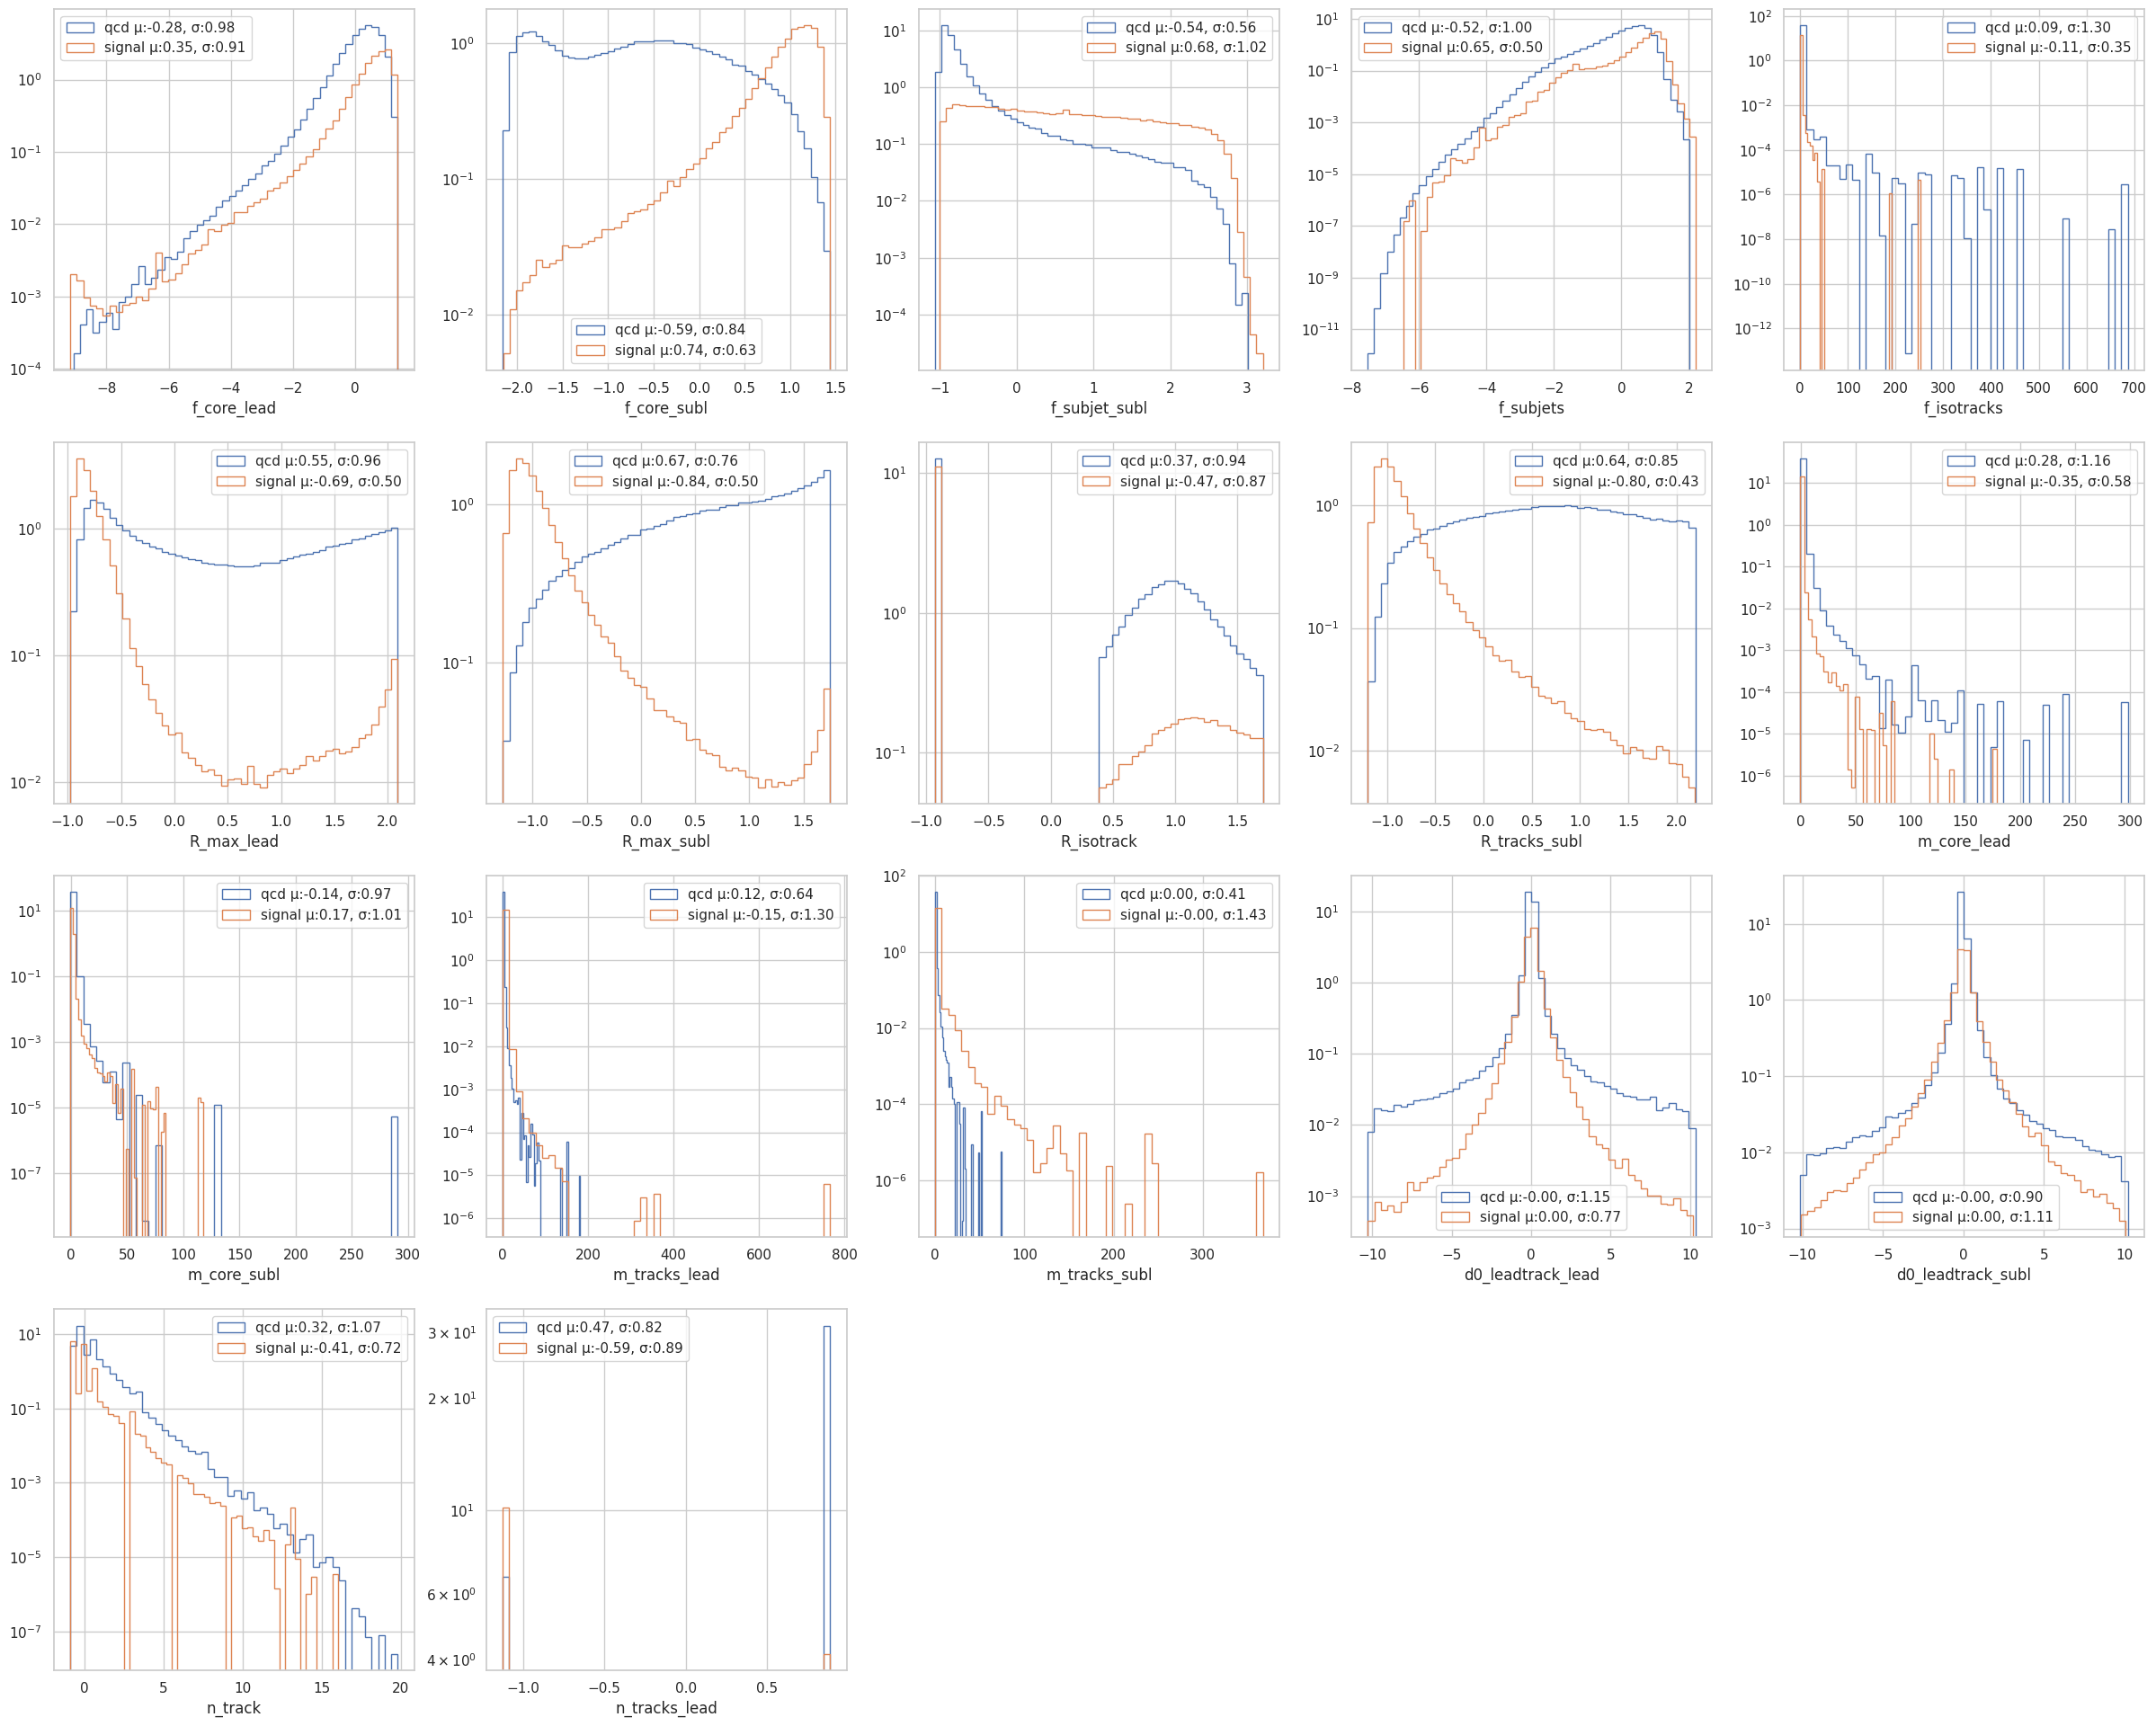

In [4]:
# Plot the Transformed Training Vars
signal = df[df.label==1]
bkg = df[df.label==0]

plt.figure(figsize=(30, 24))
def hist(variable, plot_num):
    plt.subplot(4, 5, plot_num)
    bin = 50
    plt.hist(bkg[variable], bins=bin, histtype='step', linewidth=1, weights=bkg['weight'], label=f'qcd μ:{np.mean(bkg[variable]):.2f}, σ:{np.std(bkg[variable]):.2f}')
    plt.hist(signal[variable], bins=bin, histtype='step', linewidth=1, weights=signal['weight'], label=f'signal μ:{np.mean(signal[variable]):.2f}, σ:{np.std(signal[variable]):.2f}')
    plt.xlabel(variable)
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

for i, label in tqdm(enumerate(training_vars, 1)):
    hist(label, i)

In [5]:
# Check if TensorFlow can detect the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set TensorFlow to only allocate memory as needed on the GPU, not all upfront
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU(s):", gpus)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found, training will default to CPU.")

Found 1 GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Split the dataset into training and validation sets
df['eventID_mod'] = df['event_id'] % 5

train_loc = df['eventID_mod'] < 4 # 70%
test_loc = df['eventID_mod'] == 4 # 30%

features, labels, weights = df[training_vars].values, df['label'].values, df['weight'].values

X_train, X_val, y_train, y_val, weights_train, weights_val = \
      features[train_loc], features[test_loc], labels[train_loc], labels[test_loc], weights[train_loc], weights[test_loc]


# Model configuration
input_shape = X_train.shape[1]  # Assuming X_train is a 2D array; adjust accordingly
learning_rate = 0.0005
batch_size = 2048
epochs = 100  # Set a maximum number of epochs
dropout_rate = 0  # No dropout in this case
neurons = [256, 1024, 512, 128, 32]  # Neurons in each layer

# Define the model
model = Sequential()
model.add(Dense(neurons[0], input_shape=(input_shape,), activation='relu'))
for neuron in neurons[1:]:
    model.add(Dense(neuron, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification; adjust the activation and units as necessary

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    sample_weight=weights_train,
                    validation_data=(X_val, y_val, weights_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/100
1531/1531 [==============================] - 9s 5ms/step - loss: 1.7838e-06 - accuracy: 0.9359 - weighted_accuracy: 0.9506 - val_loss: 1.0644e-06 - val_accuracy: 0.9692 - val_weighted_accuracy: 0.9707
Epoch 2/100
1531/1531 [==============================] - 7s 4ms/step - loss: 1.0258e-06 - accuracy: 0.9677 - weighted_accuracy: 0.9724 - val_loss: 1.0030e-06 - val_accuracy: 0.9694 - val_weighted_accuracy: 0.9723
Epoch 3/100
1531/1531 [==============================] - 7s 4ms/step - loss: 9.6751e-07 - accuracy: 0.9688 - weighted_accuracy: 0.9739 - val_loss: 9.2158e-07 - val_accuracy: 0.9687 - val_weighted_accuracy: 0.9751
Epoch 4/100
1531/1531 [==============================] - 7s 4ms/step - loss: 9.3565e-07 - accuracy: 0.9696 - weighted_accuracy: 0.9747 - val_loss: 9.3344e-07 - val_accuracy: 0.9671 - val_weighted_accuracy: 0.9742
Epoch 5/100
1531/1531 [==============================] - 7s 4ms/step - loss: 9.1302e-07 - accuracy: 0.9701 - weighted_accuracy: 0.9752 - val_loss: 8

24503/24503 [==============================] - 33s 1ms/step


<ipython-input-9-ac966c751e38>:20: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_dnn, 1/fpr_dnn, color='black', lw=1, label='ROC curve (area = %0.5f)' % roc_auc_dnn)


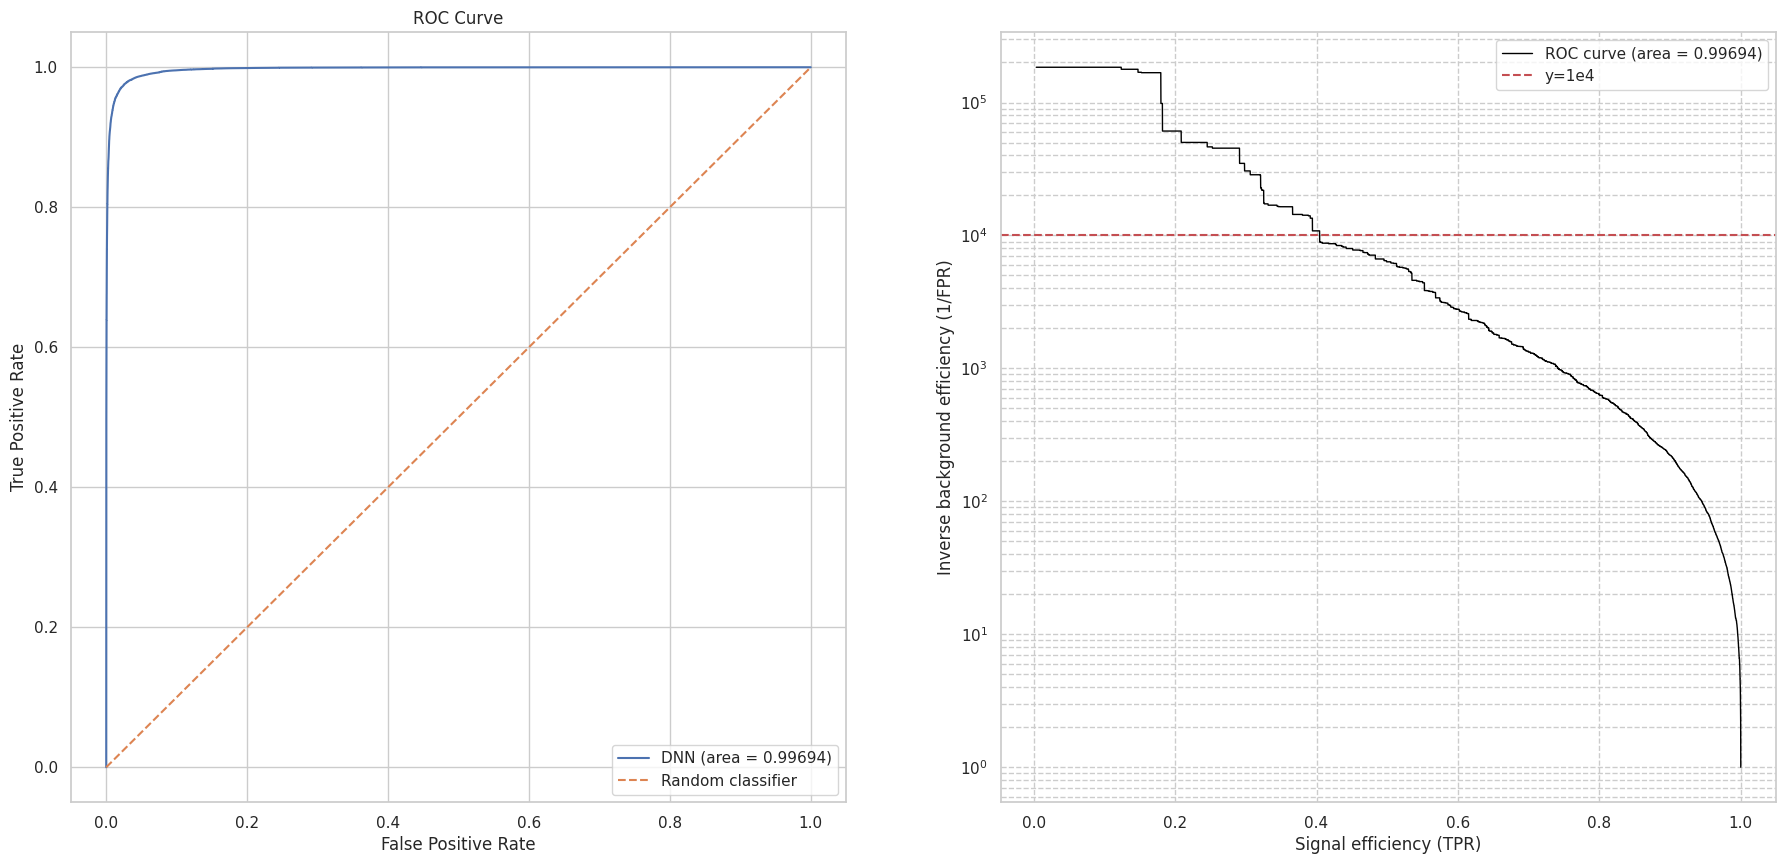

In [9]:
# Make predictions on the validation set
y_val_pred = model.predict(X_val).ravel()  # Flatten the predictions if necessary

# Calculate the ROC curve and AUC score, incorporating weights
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_val, y_val_pred, sample_weight=weights_val)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# Plotting ROC Curve
plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(fpr_dnn, tpr_dnn, label='DNN (area = {:.5f})'.format(roc_auc_dnn))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(tpr_dnn, 1/fpr_dnn, color='black', lw=1, label='ROC curve (area = %0.5f)' % roc_auc_dnn)
plt.xlabel('Signal efficiency (TPR)')
plt.ylabel('Inverse background efficiency (1/FPR)')
plt.yscale('log')
# yticks = np.linspace(0, 10e9, 71)
# plt.yticks(yticks, labels=[str(ytick) for ytick in yticks])
plt.axhline(y=1e4, color='r', linestyle='--', label='y=1e4')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()